# Clustering connection counts to determine regional grouping

In [1]:
from typing import List
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
from matplotlib.lines import Line2D 
import seaborn as sns
import itertools
from sklearn.linear_model import LinearRegression
from scipy.stats import zscore

from src.dataframe_tools import assemble_cxvectors
from vis.hex_lattice import hexplot
from vis.fig_tools import linear_cmap, subtype_cm, shortened_st


In [2]:
plt.rcdefaults()
plt.style.use('vis/lamina.mplstyle')

### SAVE FIGS? ###
save_figs = False
if save_figs:
    fig_path = '/mnt/home/nchua/Dropbox/lamina_figures/4-retvar/'

In [3]:
# Load dataframe of om->[connection counts]
tp = '210615'
lamina_links = pd.read_pickle(f'~/Data/{tp}_lamina/{tp}_linkdf.pickle')
subtypes = np.unique([*lamina_links["pre_type"], *lamina_links["post_type"]])

all_ctypes = [p for p in itertools.product(subtypes, subtypes)]  
all_ctype_labels = [f"{pre}->{post}" for pre, post in all_ctypes]
ommatidia = ommatidia = np.unique(lamina_links['pre_om'])

cxvecs = assemble_cxvectors(lamina_links)  # each om has a vector of connection counts

In [4]:
# Connection types with a mean count of less than thresh are filtered out
thresh = 1.0

cxvecs = cxvecs.loc[:, cxvecs.mean() > thresh].fillna(0)  # filter out connections with mean less than 1
cxvecs = cxvecs.rename_axis(index='om')

dra_om = ['A4', 'A5', 'B5', 'B6', 'C5', 'C6', 'D6', 'D7', 'E6', 'E7']
ndra_om = [o for o in ommatidia if o not in dra_om]
assert(len(dra_om) + len(ndra_om) == 29)
# Colors and marker styles of the different retinotopic groups
dra_c = '#434371'
ndra_c = '#C64191'
dra_m = '^'
ndra_m = 'v'
# Dict with color for each cell subtypes
st_cm = subtype_cm()

In [5]:
# Specifies colors for DRA and non-DRA ommatidia
def om_colors(om_list: List, dra_om: List=dra_om, as_rgb: bool=False, 
              dra_c: str=dra_c, ndra_c: str=ndra_c) -> List:
    
    c_list = []
    for o in om_list:
        if str(o) in dra_om:
            c_list.append(dra_c)
        else:
            c_list.append(ndra_c)
    if as_rgb:
        return [tuple(int(h.lstrip('#')[i:i+2], 16)/255.0 for i in (0, 2, 4)) for h in c_list] 
    else:
        return c_list
    
def om_markers(om_list: List, dra_om: List=dra_om, 
               dra_m: str=dra_m, ndra_m: str=ndra_m) -> List:
    
    m_list = []
    for o in om_list:
        if o in dra_om:
            m_list.append(dra_m)
        else:
            m_list.append(ndra_m)
            
    return m_list

## Clustering ommatidia by all connection types

Index(['LMC_2->LMC_1', 'LMC_2->LMC_2', 'LMC_2->LMC_3', 'LMC_2->LMC_4',
       'LMC_2->R2R5', 'LMC_2->R7', 'LMC_2->R7p', 'LMC_2->R8', 'LMC_2->centri',
       'LMC_N->LMC_1', 'LMC_N->LMC_2', 'LMC_N->LMC_3', 'R1R4->LMC_1',
       'R1R4->LMC_2', 'R1R4->LMC_3', 'R1R4->LMC_4', 'R1R4->LMC_N',
       'R1R4->R2R5', 'R1R4->R7p', 'R1R4->centri', 'R2R5->LMC_1', 'R2R5->LMC_2',
       'R2R5->LMC_3', 'R2R5->LMC_4', 'R2R5->R2R5', 'R2R5->R7p', 'R2R5->R8',
       'R2R5->centri', 'R3R6->LMC_1', 'R3R6->LMC_2', 'R3R6->LMC_3',
       'R3R6->LMC_4', 'R3R6->LMC_N', 'R3R6->R2R5', 'R3R6->R7p', 'R3R6->centri',
       'centri->LMC_1', 'centri->LMC_2', 'centri->LMC_3', 'centri->LMC_4',
       'centri->R1R4', 'centri->R2R5', 'centri->R3R6', 'centri->R7',
       'centri->R7p', 'centri->R8', 'centri->centri', 'R3R6->eLMC_2',
       'R1R4->eLMC_2', 'R3R6->eLMC_4', 'R2R5->eLMC_4', 'R1R4->eLMC_4',
       'LMC_2->eLMC_4', 'centri->eLMC_4'],
      dtype='object')


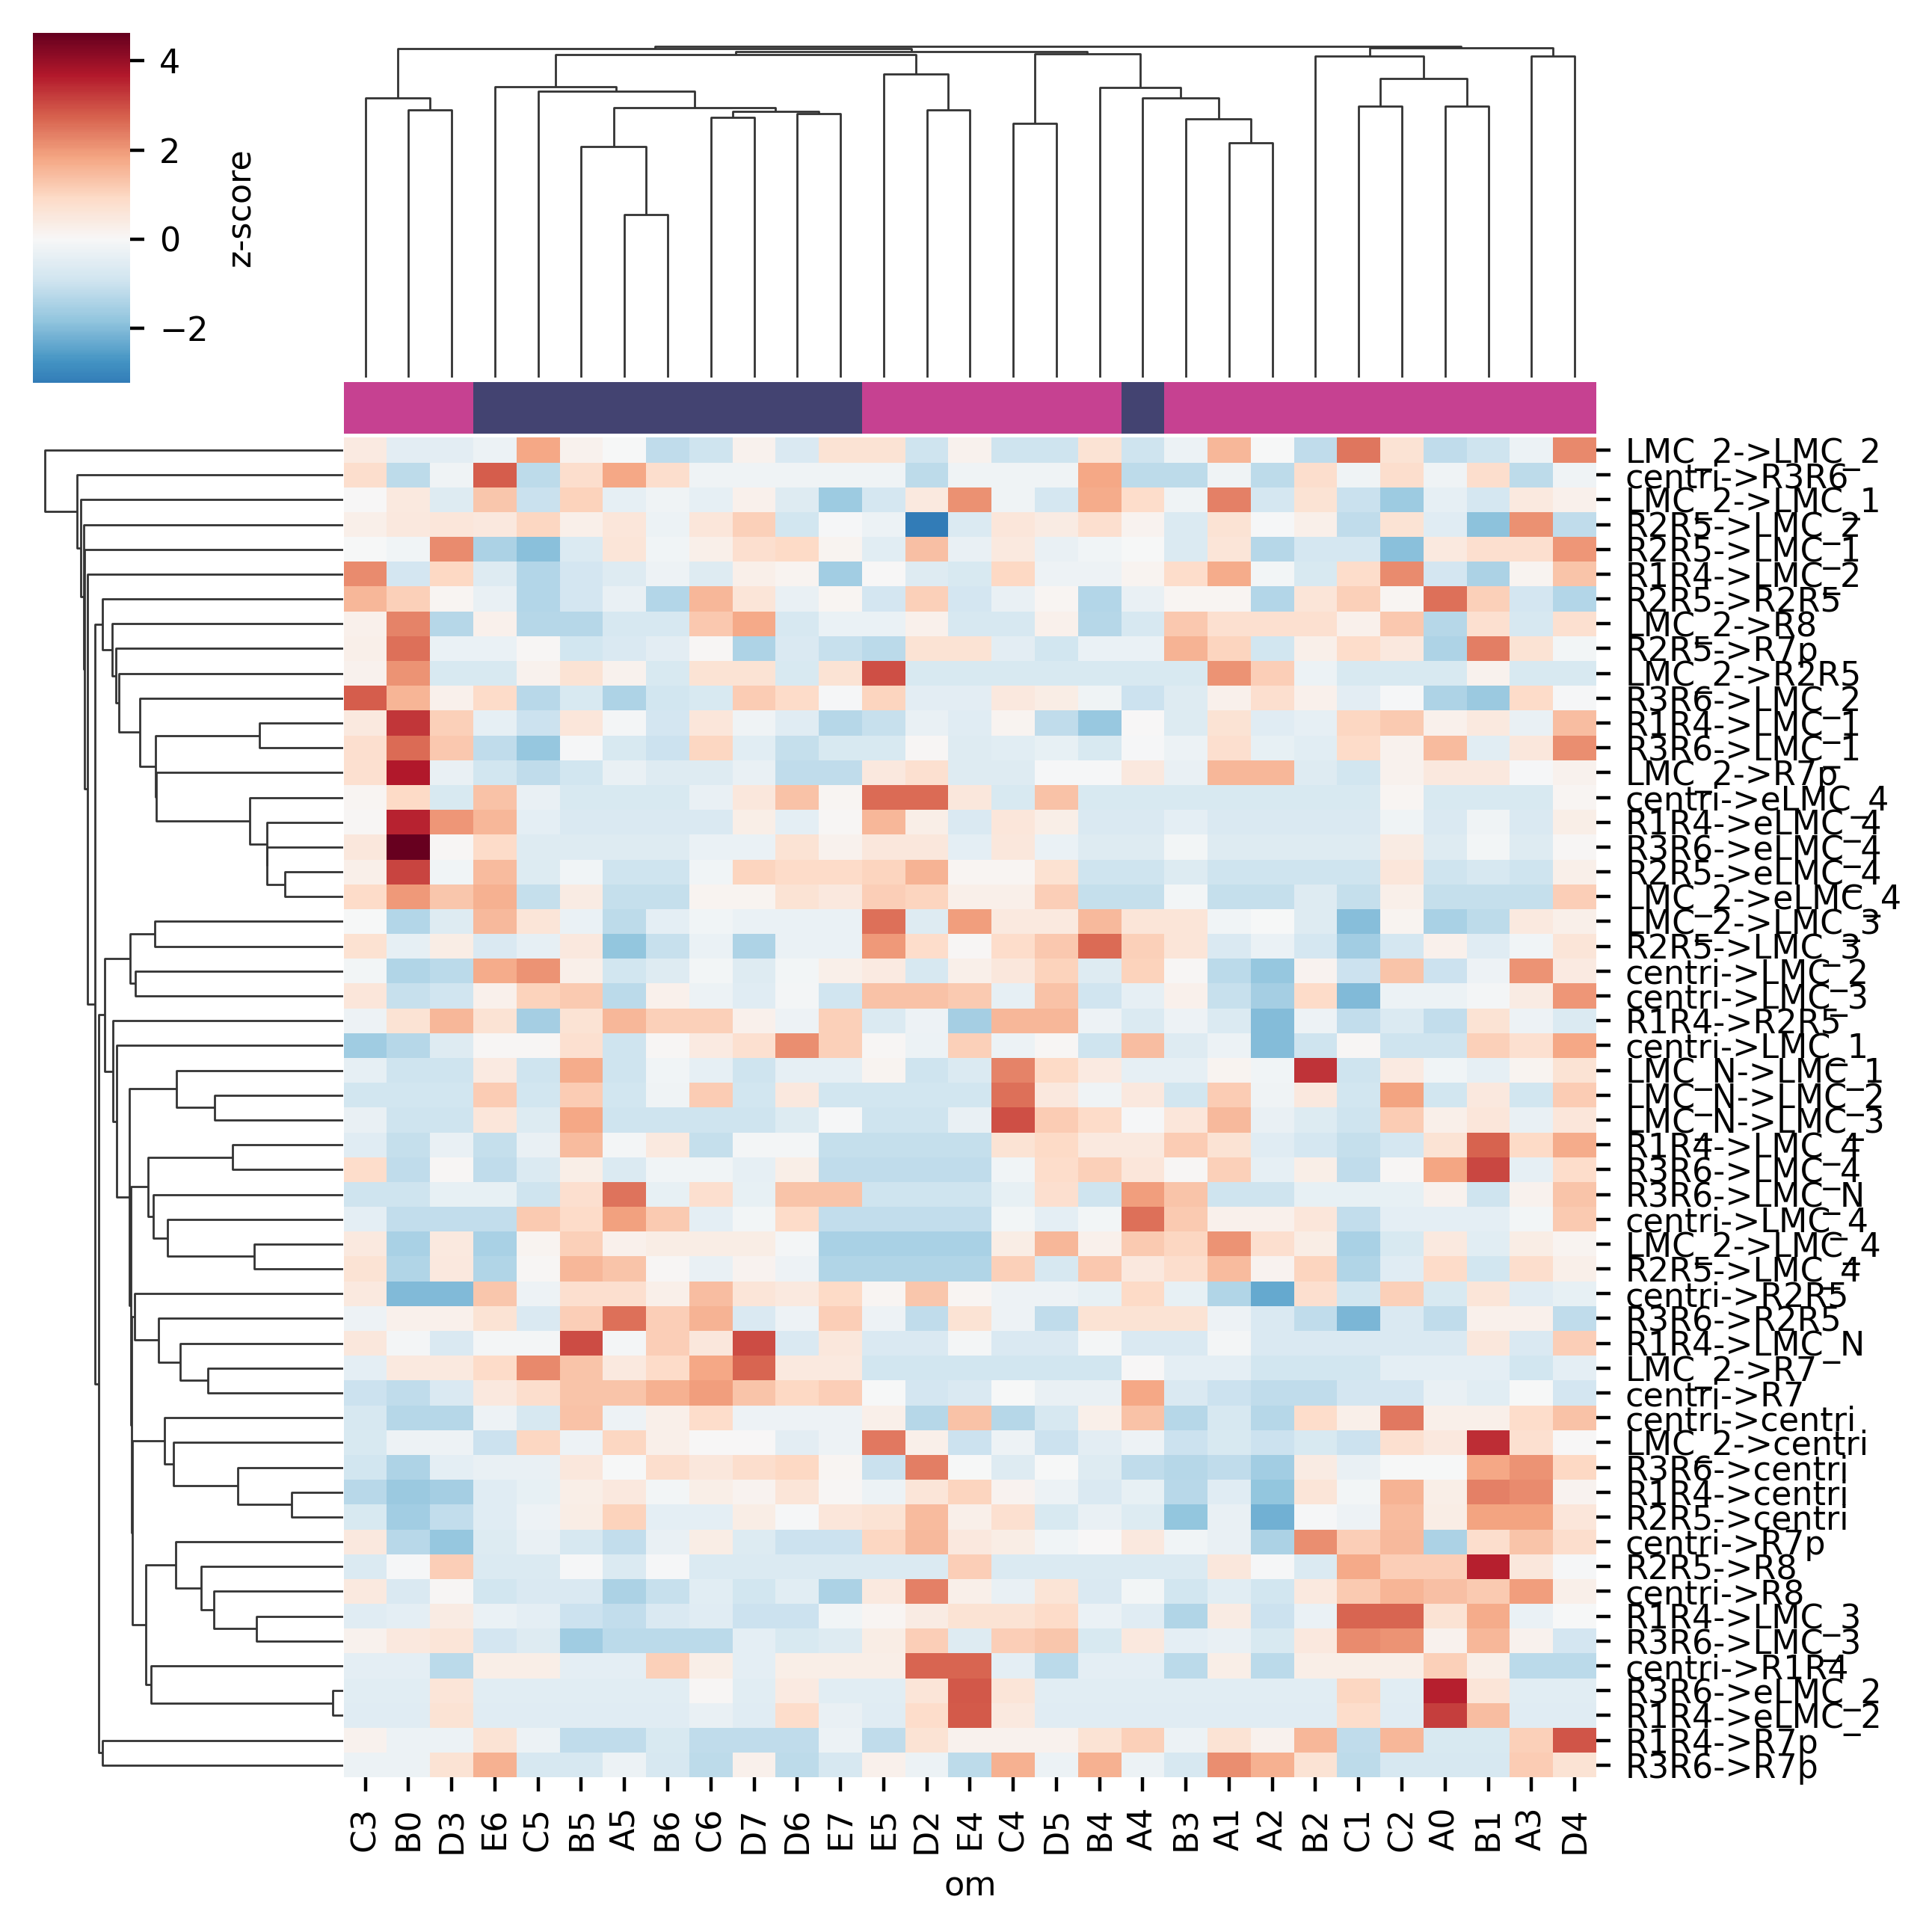

In [6]:
data = cxvecs

z = data.apply(zscore)
z = z.T
print(z.index)
x_c = om_colors(z.columns)
y_c = [st_cm[cx.split('->')[1]] for cx in z.index]

clus = sns.clustermap(z, row_cluster=True, figsize=[6.5,6.5], cmap='RdBu_r', center=0, cbar_kws={'label': 'z-score'}, 
                      col_colors=x_c, 
                      yticklabels=z.index, 
                      metric='cosine', method='single')
plt.show()

# if save_figs:
#     clus.savefig(f'/mnt/home/nchua/Dropbox/lamina_figures/om_clus_lvfinputs_zscore_thresh{thresh}.svg')
#     clus.savefig(f'/mnt/home/nchua/Dropbox/lamina_figures/om_clus_lvfinputs_zscore_thresh{thresh}.png')

## Clustering ommatidia by common connections
- Exclude connections involving LMC_4 and eLMC_2 (L2 from another cartridge), because these are not present in every ommatidium

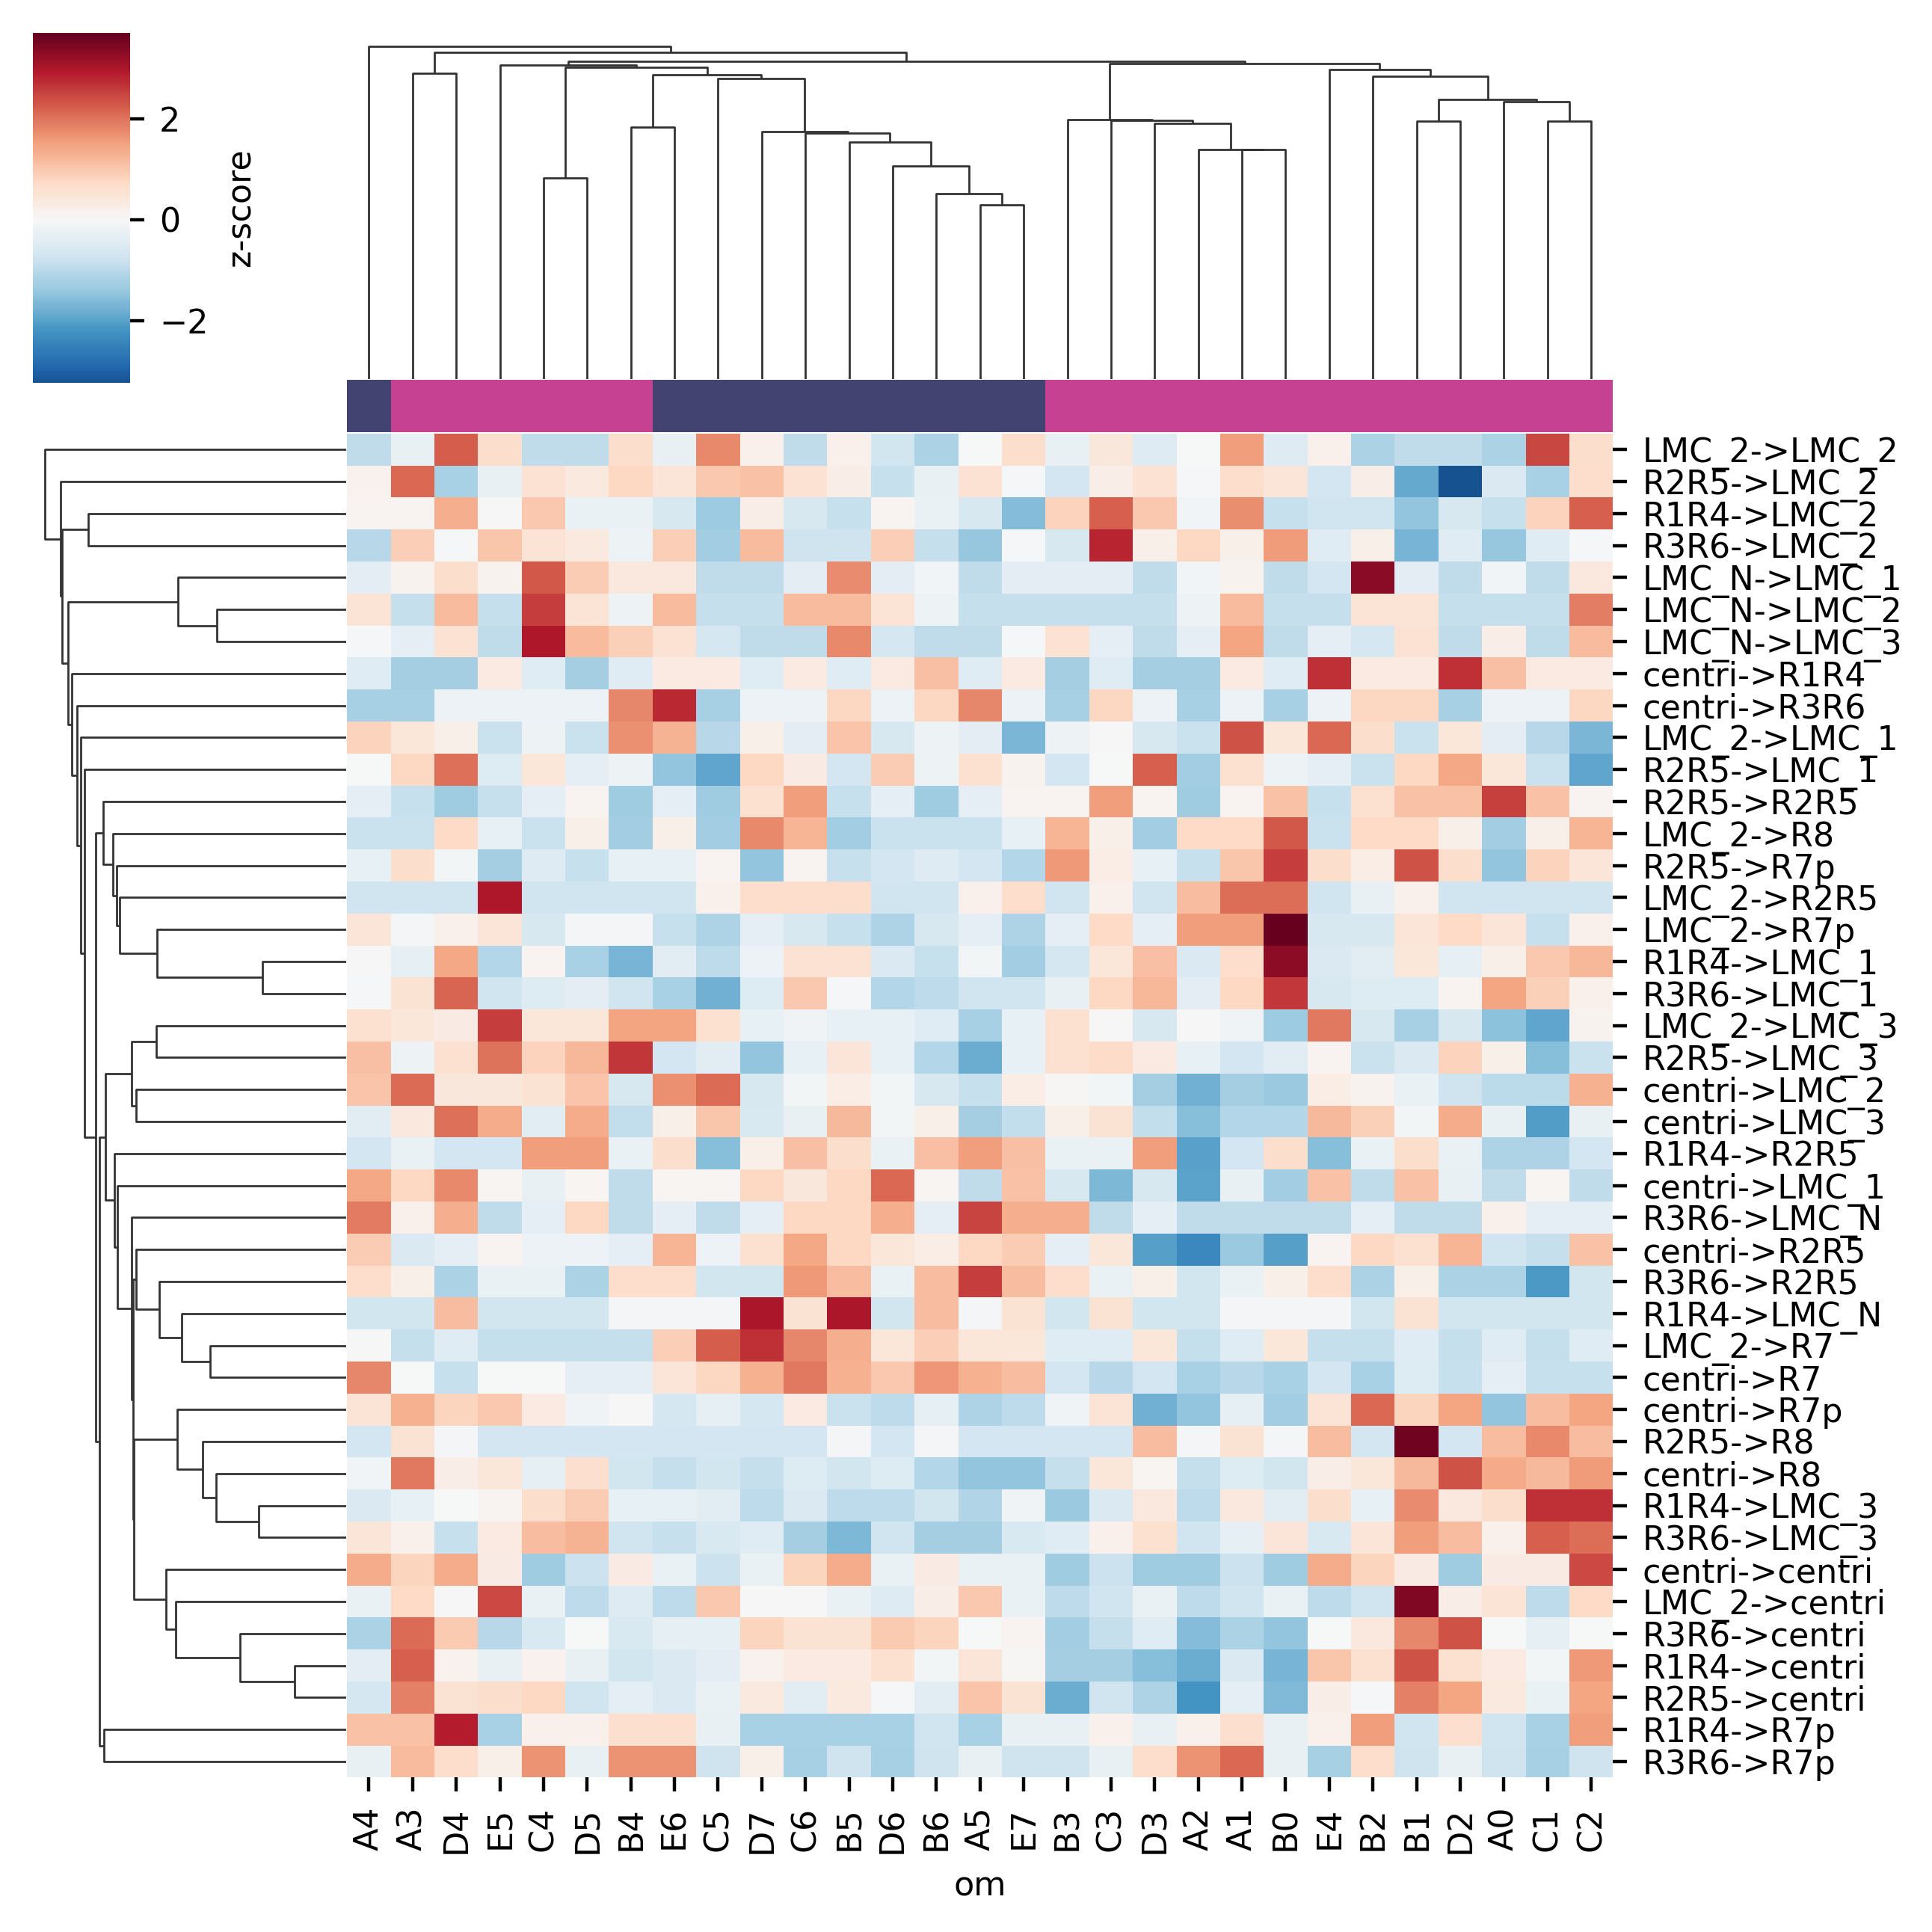

In [7]:
data = cxvecs.loc[:, [c for c in cxvecs.columns if ('LMC_4' not in c) and ('eLMC_2' not in c)]]

z = data.apply(zscore)
z = z.T

x_c = om_colors(z.columns)
y_c = [st_cm[cx.split('->')[1]] for cx in z.index]

clus = sns.clustermap(z, row_cluster=True, figsize=[6.5,6.5], cmap='RdBu_r', center=0, cbar_kws={'label': 'z-score'}, 
                      col_colors=x_c, 
                      yticklabels=z.index, 
                      metric='cosine', method='single')
plt.show()
# if save_figs:
#     clus.savefig(f'/mnt/home/nchua/Dropbox/lamina_figures/om_clus_lvfinputs_zscore_thresh{thresh}.svg')
#     clus.savefig(f'/mnt/home/nchua/Dropbox/lamina_figures/om_clus_lvfinputs_zscore_thresh{thresh}.png')

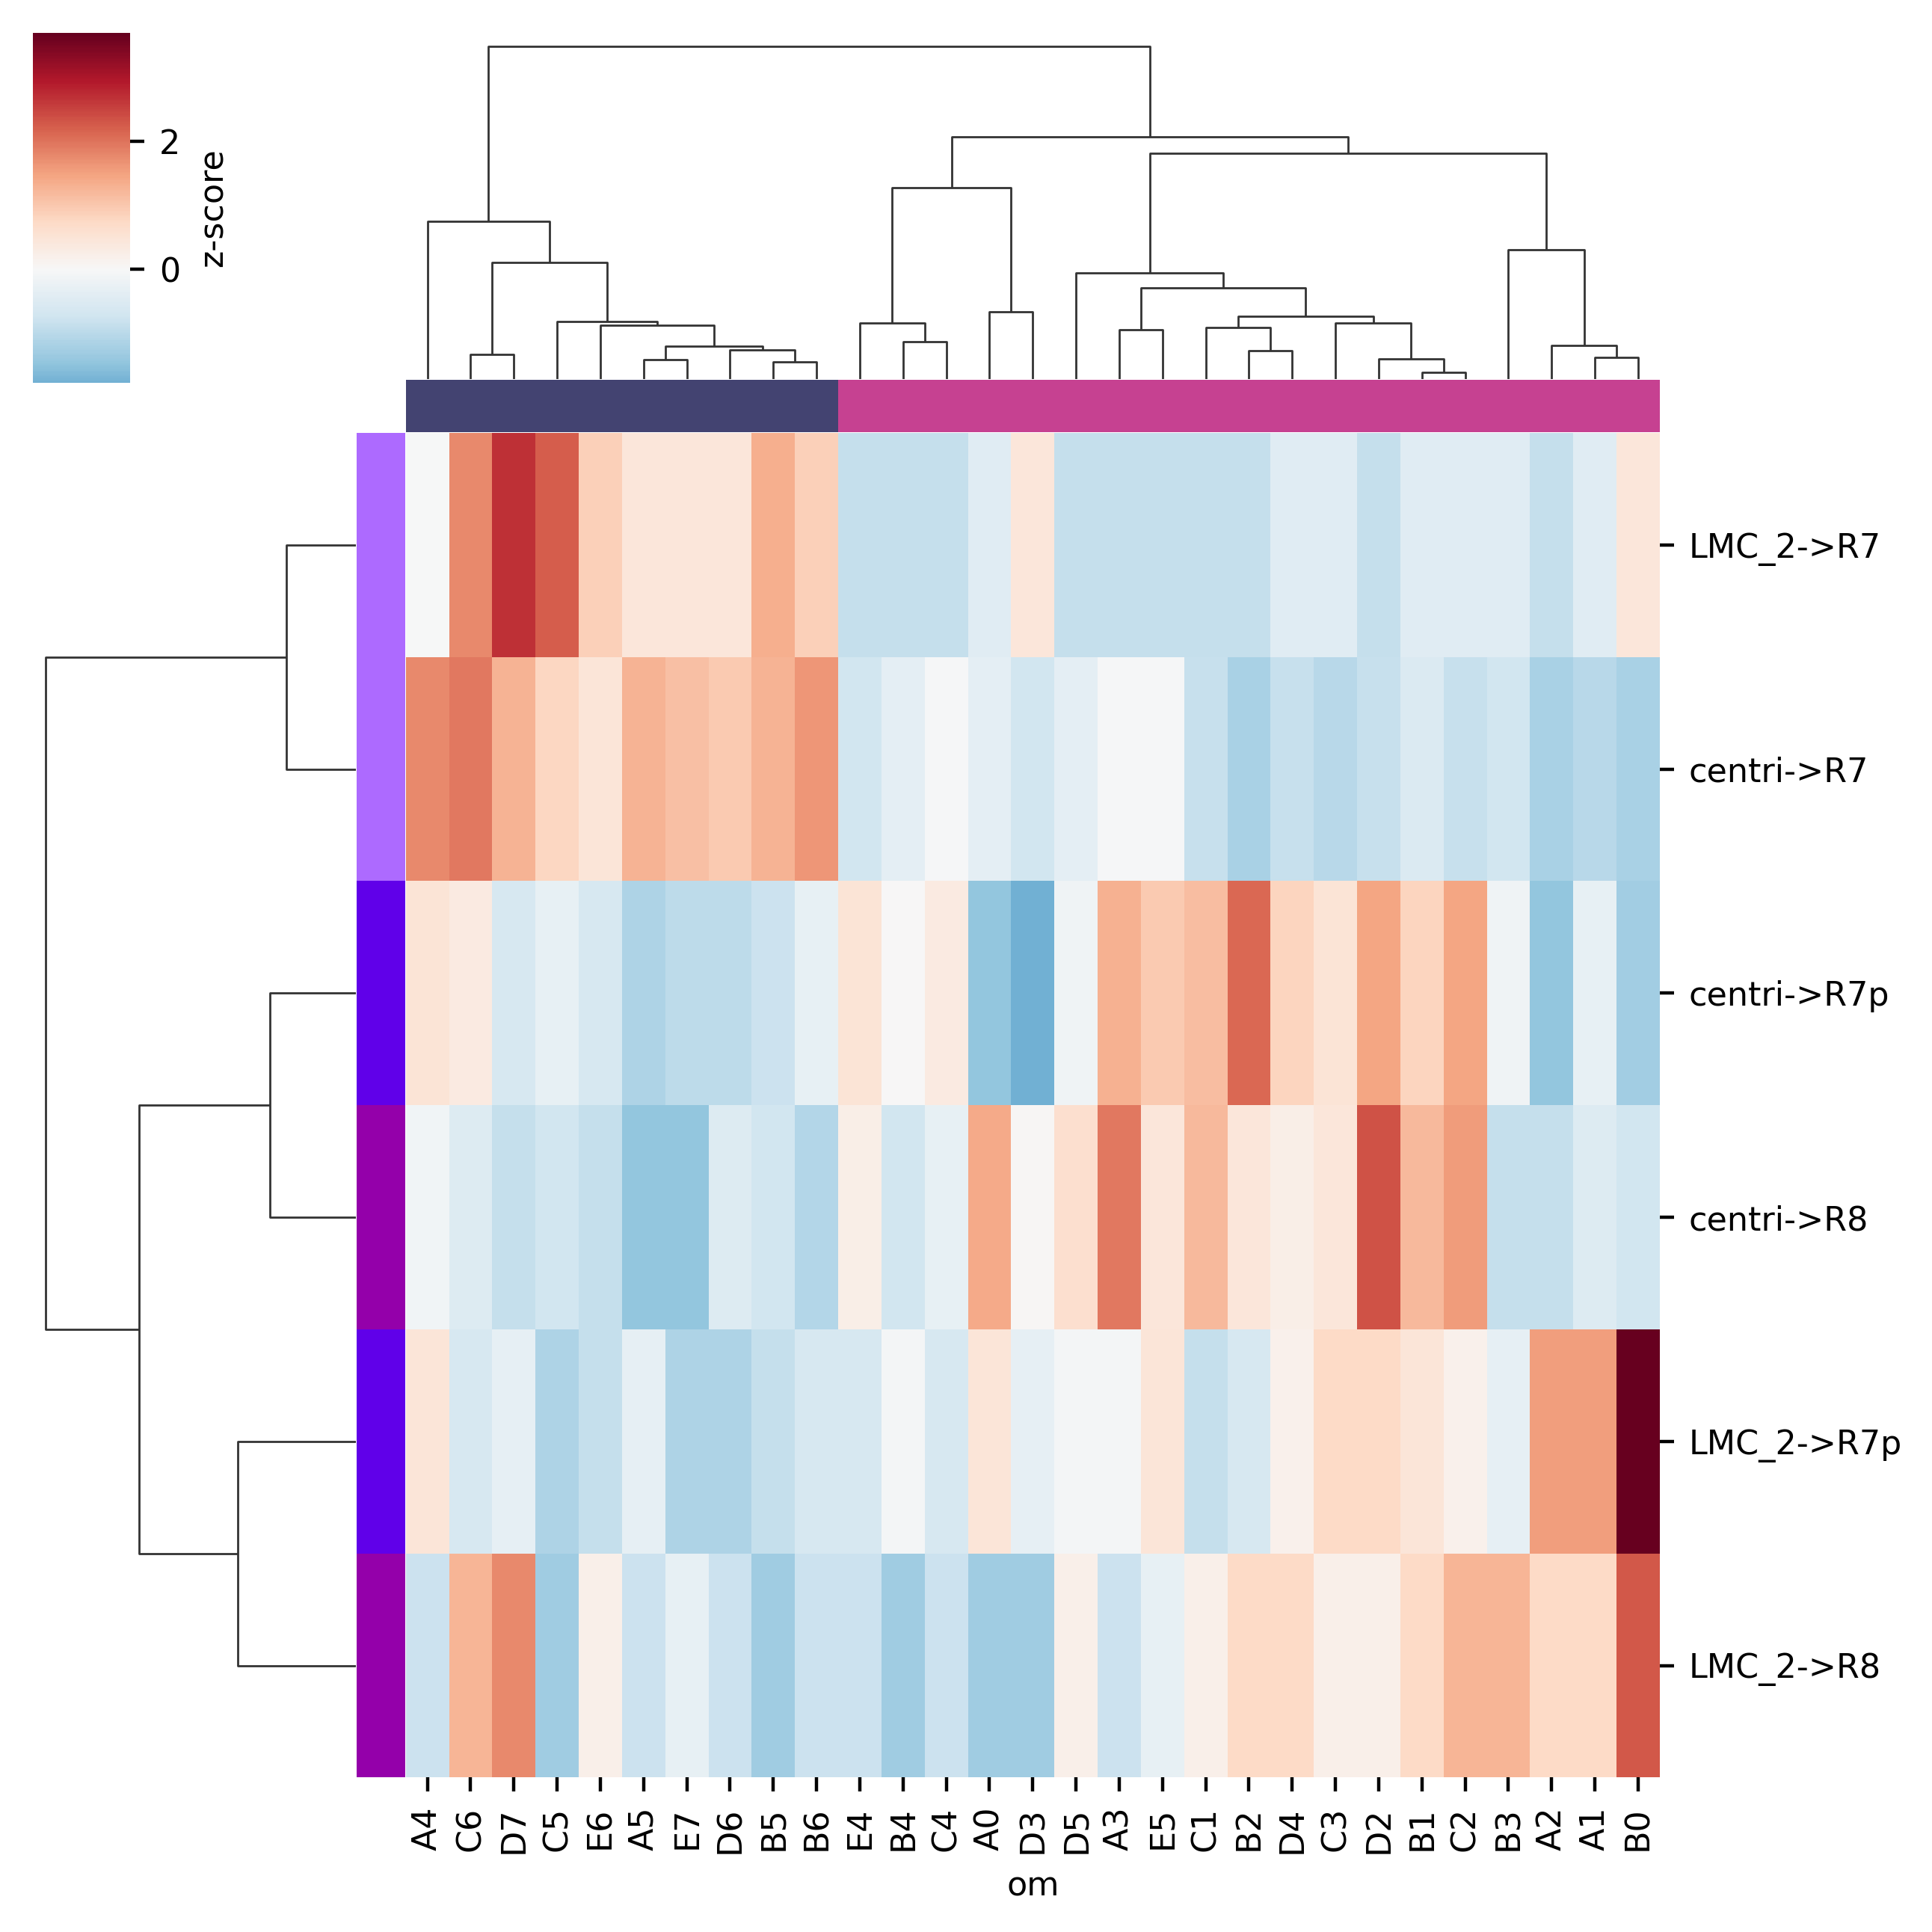

In [8]:
data = cxvecs.filter(regex='(centri|LMC_2)->R(7|8)', axis=1)

z = data.apply(zscore)
z = z.T

x_c = om_colors(z.columns)
y_c = [st_cm[cx.split('->')[1]] for cx in z.index]

clus = sns.clustermap(z, row_cluster=True, figsize=[6.5,6.5], cmap='RdBu_r', center=0, cbar_kws={'label': 'z-score'}, 
                      col_colors=x_c, row_colors=y_c,
                      yticklabels=z.index, 
                      metric='cosine', method='average')
plt.show()

# if save_figs:
#     clus.savefig(f'/mnt/home/nchua/Dropbox/lamina_figures/om_clus_lvfinputs_zscore_thresh{thresh}.svg')
#     clus.savefig(f'/mnt/home/nchua/Dropbox/lamina_figures/om_clus_lvfinputs_zscore_thresh{thresh}.png')

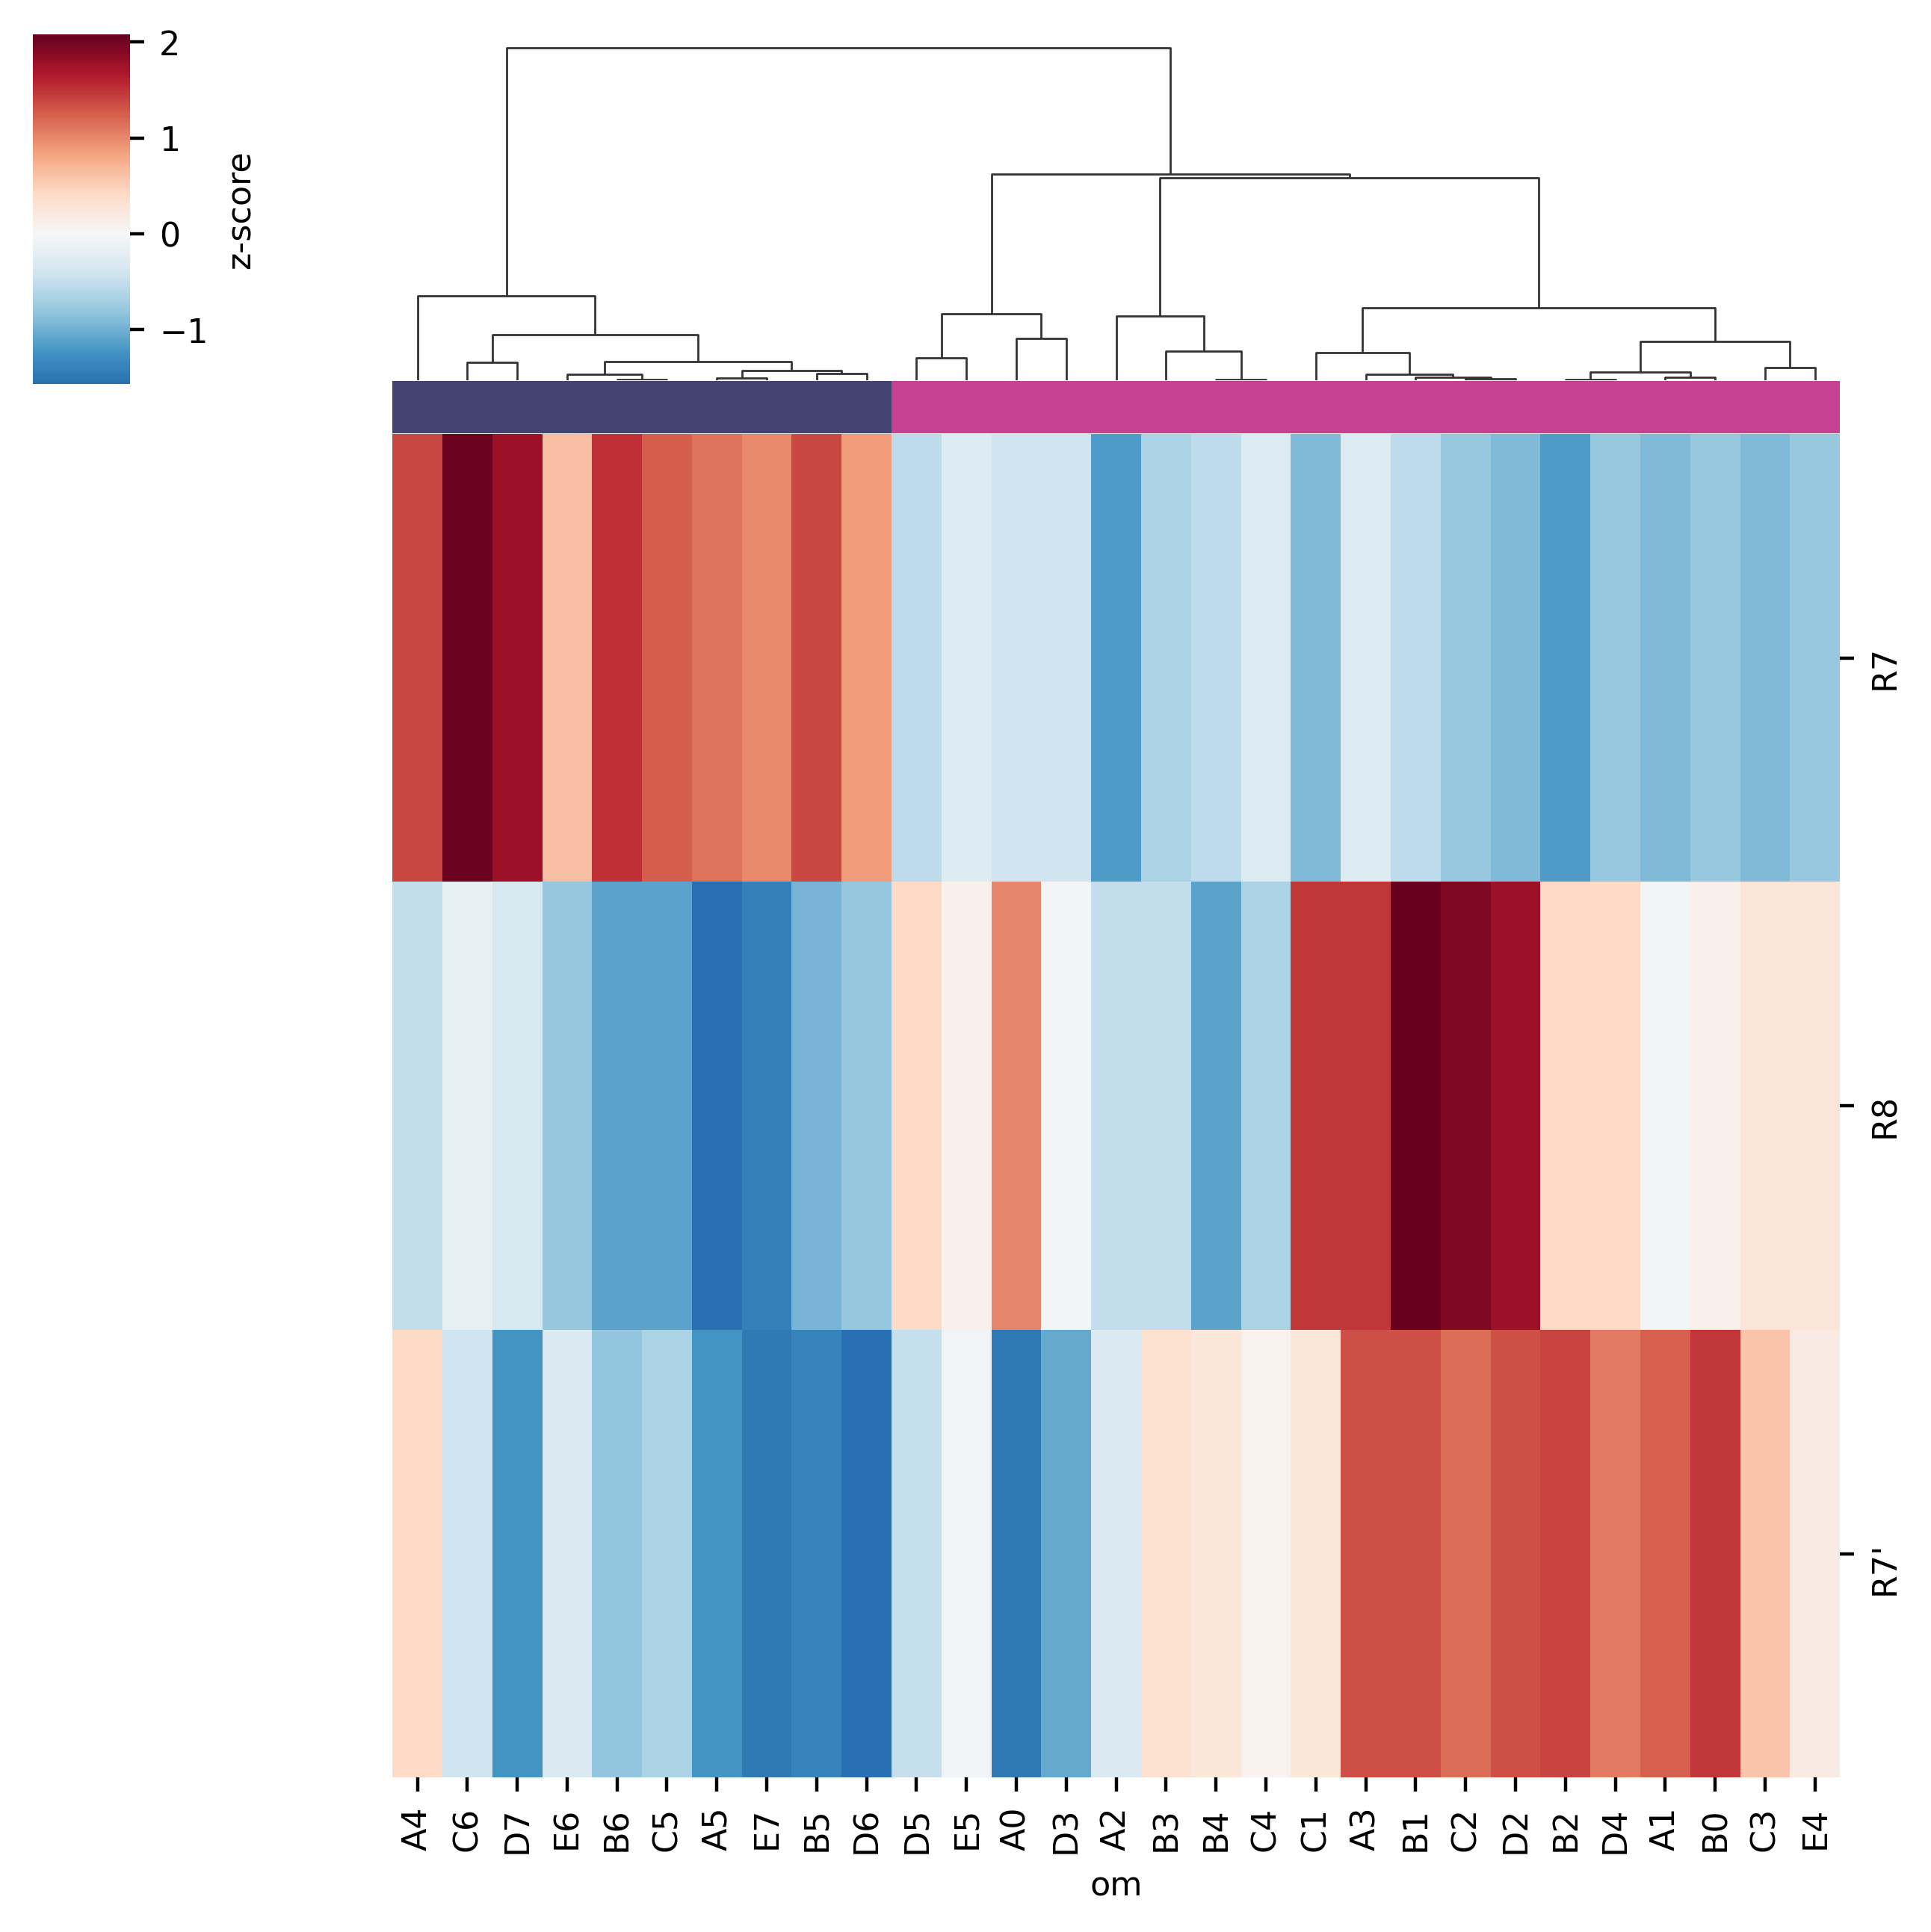

In [12]:
data = pd.DataFrame([cxvecs.filter(regex='->R7$').sum(axis=1), 
                            cxvecs.filter(regex='->R8$').sum(axis=1), 
                            cxvecs.filter(regex='->R7p$').sum(axis=1)], index=['R7', 'R8', "R7'"]). T

#display(total_inputs)

z = data.apply(zscore)
z = z.T

x_c = om_colors(z.columns)
#y_c = [st_cm[cx.split('->')[1]] for cx in z.index]

clus = sns.clustermap(z, row_cluster=False, figsize=[6.5,6.5], cmap='RdBu_r', center=0, cbar_kws={'label': 'z-score'}, 
                      col_colors=x_c, 
                      yticklabels=z.index, 
                      metric='cosine', method='average')
plt.show()

# if save_figs:
#     clus.savefig(f'/mnt/home/nchua/Dropbox/lamina_figures/om_clus_lvfinputs_zscore_thresh{thresh}.svg')
#     clus.savefig(f'/mnt/home/nchua/Dropbox/lamina_figures/om_clus_lvfinputs_zscore_thresh{thresh}.png')